In [ ]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy import stats

## Location files

In [ ]:
loc_files = os.path.join('..', 'data')
loc_file_titanic = os.path.join(loc_files, 'titanic.xlsx')
loc_file_7_dwarfs = os.path.join(loc_files, '7_dwarfs_train.csv')
loc_file_murders = os.path.join(loc_files, 'murder_rates.csv')

## Read data

In [ ]:
df_titanic = pd.read_excel(loc_file_titanic, sheet_name="train_minimal")
df_7_dwarfs_raw = pd.read_csv(loc_file_7_dwarfs)

## Oefening 1: gemiddelde berekenen

In [ ]:
def compute_mean(x):
    
    n = len(x)
    total_sum = sum(x)
    return total_sum / n

In [5]:
mean_fare = compute_mean(df_titanic['Fare'])
mean_fare_check = df_titanic['Fare'].mean()
print(np.abs(mean_fare - mean_fare_check) < 10 ** (-8))

True


In [6]:
prob_survived = compute_mean(df_titanic['Survived'])
prob_survived_check = df_titanic['Survived'].mean()
print(np.abs(prob_survived - prob_survived_check) < 10 ** (-8))

True


In [7]:
prob_survived_check

0.3838383838383838

## Oefening 2: 7 dwarfs train, mediane dag

Clean/preprocess data

In [8]:
df_7_dwarfs = df_7_dwarfs_raw.copy()
df_7_dwarfs['datetime'] = pd.to_datetime(df_7_dwarfs['datetime'], format = '%d/%m/%Y %H:%M')
df_7_dwarfs['date'] = df_7_dwarfs['datetime'].dt.date
idxs = (df_7_dwarfs.SPOSTMIN >= 0) & (~df_7_dwarfs['SPOSTMIN'].isnull())
df_7_dwarfs = df_7_dwarfs.loc[idxs]

Group per day & find median

In [9]:
df_7_dwarfs_daily = df_7_dwarfs.groupby('date')['SPOSTMIN'].mean()
print(f"On a median day there is an average waiting time of {np.round(df_7_dwarfs_daily.median(), 2)} minutes")

On a median day there is an average waiting time of 75.71 minutes


Find and visualize a median day.

In [10]:
median_day = df_7_dwarfs_daily.sort_values().index[len(df_7_dwarfs_daily) // 2]
df_median = df_7_dwarfs[df_7_dwarfs.date == median_day]

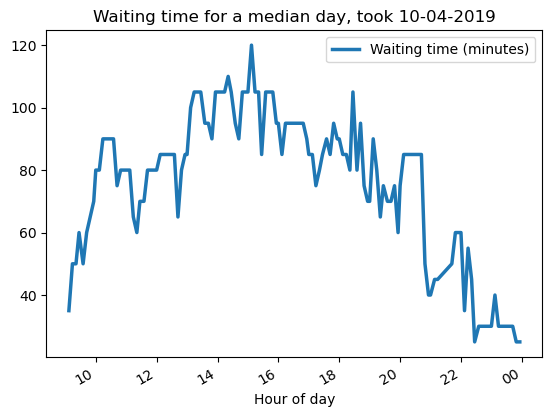

In [11]:
ax = df_median.plot(x = 'datetime', y = 'SPOSTMIN', lw = 2.5)
ax.legend(["Waiting time (minutes)"])
ax.set_xlabel("Hour of day")
ax.set_title(f"Waiting time for a median day, took {median_day.strftime('%d-%m-%Y')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

(18628.0, 18993.0)

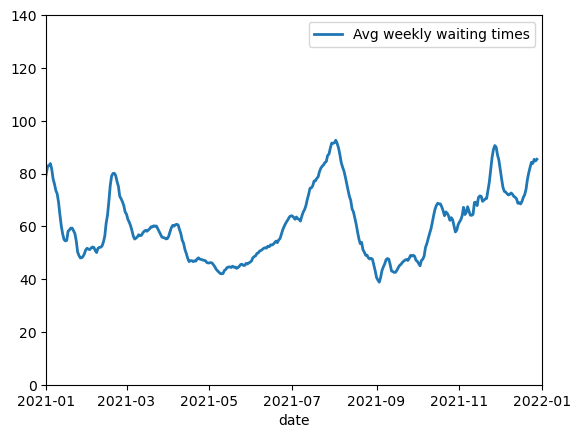

In [12]:
df_7_dwarfs_weekly = df_7_dwarfs_daily.rolling(window = 7).mean().iloc[7:].copy()
ax = df_7_dwarfs_weekly.plot(lw = 2)
ax.set_ylim([0, 140])
ax.legend(["Avg weekly waiting times"])
ax.set_xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 1, 1)])

In [13]:
df_7_dwarfs['DoW'] = df_7_dwarfs.datetime.dt.strftime('%A').astype(pd.CategoricalDtype(
                        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                        ordered=True))

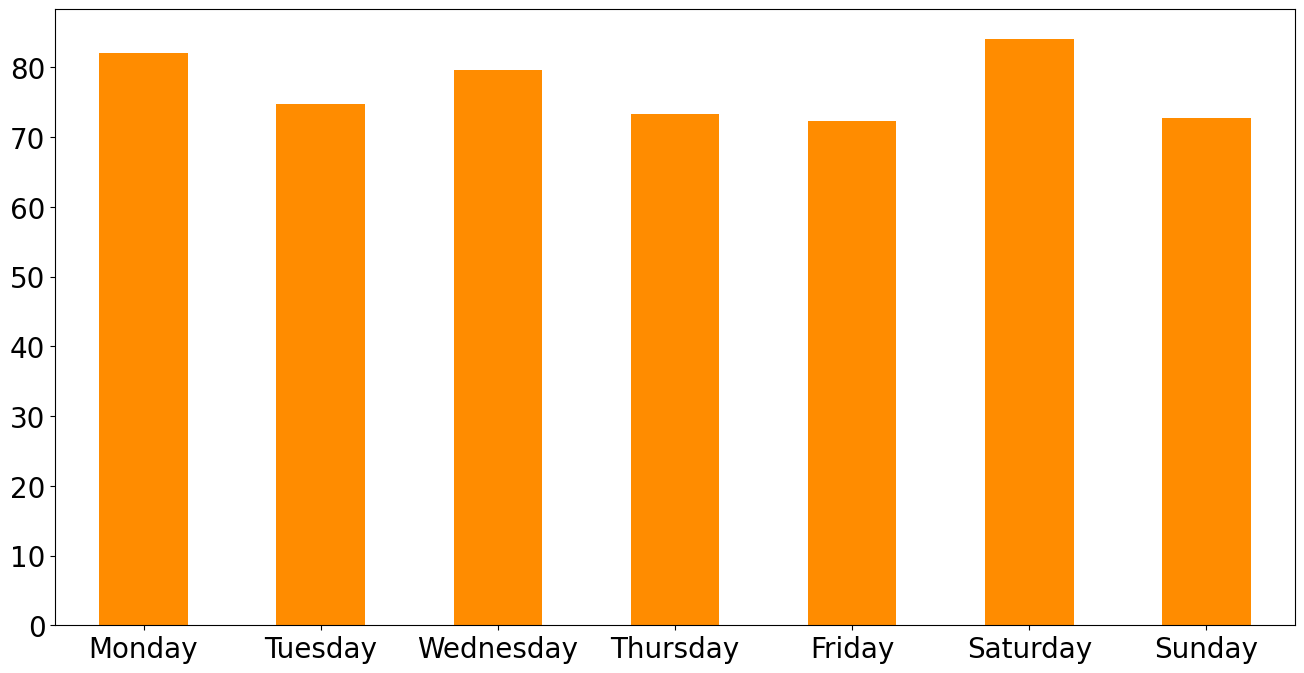

In [14]:
fig, ax = plt.subplots(figsize = (16, 8))
df_avgperday = df_7_dwarfs.groupby('DoW')['SPOSTMIN'].mean()
ax = df_avgperday.plot.bar(color='darkorange')
ax.tick_params(which = 'both', labelsize=20, rotation = 0)
ax.set_xlabel('');

## Oefening 3: Trimmed mean

Define a function which computes the trimmed mean

In [15]:
def trimmed_mean(x, p_range):

    # sort the list in ascending order
    x_sorted = sorted(x)

    trimmed_means = list()
    for p in p_range:
        # compute the number of elements to be trimmed from both ends
        n_trim = int(len(x) * p / 100)

        # Special case: regular mean.
        if n_trim == 0:
            trimmed_means.append( sum(x) / len(x) )
            continue
        # Special case: nothing left
        elif n_trim == len(x) // 2:
            trimmed_means.append(np.median(x))
            continue
    
        # slice the sorted list to remove the trimmed elements
        x_trimmed = x_sorted[n_trim : -n_trim]
        
        # compute the mean of the remaining elements
        trimmed_means.append( sum(x_trimmed) / len(x_trimmed) )
    
    return trimmed_means

Apply this function to the 7 dwarfs train ranging p from 0 to $\frac{n-1}{2}$ with $n$ the number of days in the dataset.

In [16]:
all_waiting_times = df_7_dwarfs['SPOSTMIN'].values
n_days = len(all_waiting_times)
p_range = np.linspace(0, 50, num = 50)
trimmed_means = trimmed_mean(all_waiting_times, p_range)

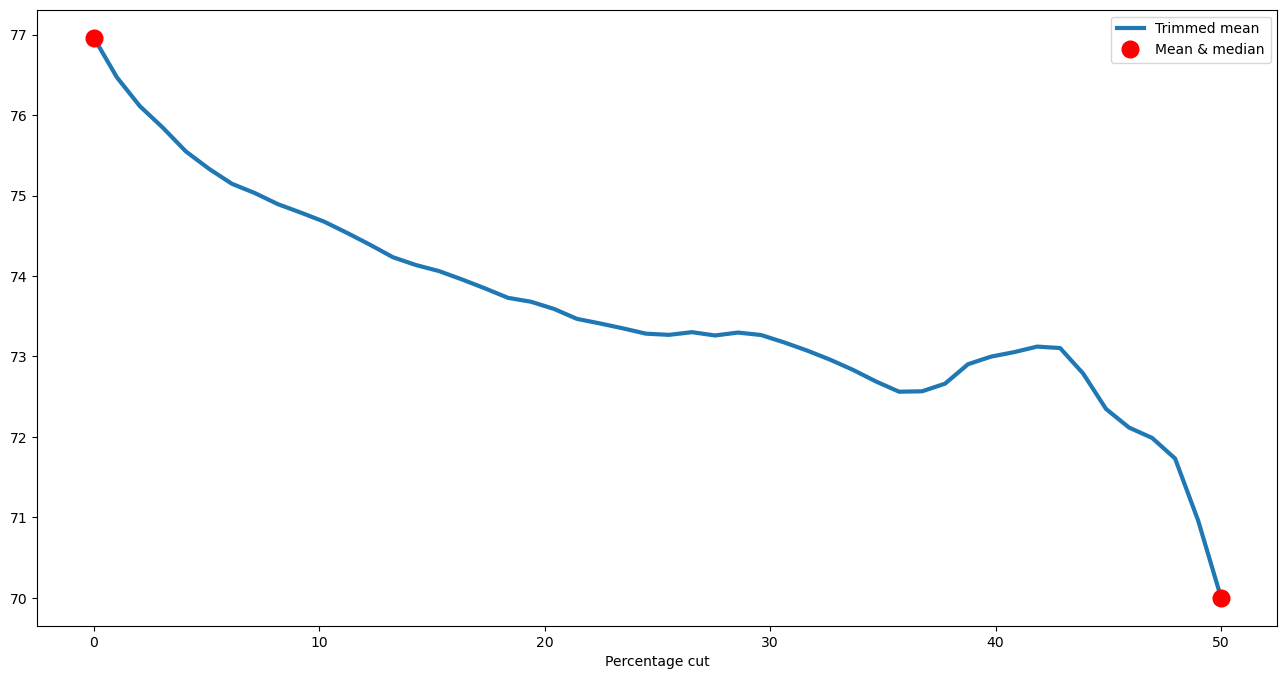

In [17]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(p_range, trimmed_means, lw = 3, label = "Trimmed mean")
ax.plot([0, 50], [np.mean(all_waiting_times), np.median(all_waiting_times)], linestyle = '', marker = 'o', markersize = 12, color = 'r', label = "Mean & median")
ax.set_xlabel("Percentage cut")
# ax.set_ylim([0, 82])
ax.legend()

## Oefening 4: weighted mean

In [18]:
# Read data
df_murder_rate = pd.read_csv(loc_file_murders)

In [23]:
vals_no_weights = df_murder_rate['Murder.Rate'].aggregate(['mean', 'median', lambda x : trimmed_mean(x, [10])[0]]).values

## Weighted values ##
df_murder_rate['Weighted murder rate'] = df_murder_rate['Population'] * df_murder_rate['Murder.Rate']

# Mean
weighted_mean = df_murder_rate['Weighted murder rate'].sum() / df_murder_rate['Population'].sum()

# Weighted median
df_murder_rate = df_murder_rate.sort_values(by='Murder.Rate').reset_index(drop = True)
half_pop = df_murder_rate.Population.sum() // 2
df_murder_rate['cumm_population'] = df_murder_rate.Population.cumsum()
median_row = df_murder_rate.query("cumm_population > @half_pop").iloc[0]
weighted_median = median_row['Murder.Rate']

# Trimmed mean
df_murder_rate = df_murder_rate.sort_values(by = 'Weighted murder rate')
nvals = len(df_murder_rate) // 10
weighted_trimmed_mean = df_murder_rate.iloc[nvals : -nvals]['Weighted murder rate'].sum()/\
                                      df_murder_rate.iloc[nvals : -nvals]['Population'].sum()


value_with_weights = np.array([weighted_mean, weighted_median, weighted_trimmed_mean])

df_comparison = pd.DataFrame(
                                data = np.concatenate([vals_no_weights[:, None], value_with_weights[:, None]], axis = 1),
                                index = ['Mean', 'Median', 'Trimmed mean'],
                                columns = ['Without weights', 'With weights']
                            )

df_comparison

,Without weights,With weights
Mean,4.066,4.445834
Median,4.000,4.400000
Trimmed mean,3.945,4.304478


5.6